# Classificadores

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler

from IPython import display

In [2]:
display.set_matplotlib_formats('jpg', quality=94)
plt.style.use('fivethirtyeight')
plt.rcParams['figure.dpi'] = 100

### Regressão Logística Gradiente Descendente

In [3]:
def rss(y_true, y_pred):
    return np.sum(np.square(y_true - y_pred))

In [4]:
def l2_penalty(penalty, W):
    return penalty * (np.sum(W*W) / 2)

In [5]:
class RegressaoLogisticaGD:
    def __init__(self, limiar=0.5, penalty=0):
        self.W = None
        self.b = None
        self.limiar = limiar
        self.penalty = penalty
        self.classes = None

    def fit(self, X, y, learning_rate=0.1, epochs=10, batch_size=None, tool=None, return_errors=False):
        y = y.reshape(-1, 1)
        self._multiclass = np.unique(y).shape[0] > 2
        if not self._multiclass:
            self.W = np.random.normal(loc=0, scale=0.1, size=(X.shape[1]))
            self.b = 0
            errors = self._gradient_descent_runner(X, y, learning_rate, epochs, tool, batch_size)
            if return_errors:
                errors = np.pad(errors, (0, epochs - len(errors)), mode='minimum')
                return errors
        else:
            self.W = []
            self.b = []
            self.classes = dict()
            errors = []
            for i, c in enumerate(np.unique(y)):
                clf = RegressaoLogisticaGD(self.limiar, self.penalty)
                err = clf.fit(
                    X, (y == c),
                    learning_rate=learning_rate, epochs=epochs, 
                    batch_size=batch_size, tool=tool, return_errors=True
                )
                errors.append(err)
                self.W.append(clf.W)
                self.b.append(clf.b)
                self.classes[i] = c
            
            errors = np.array(errors).mean(axis=0)
            self.W = np.array(self.W)
            self.b = np.array(self.b)
            if return_errors:
                return errors
    
    def predict(self, X):
        if not self._multiclass:
            y_hat = (np.dot(X, self.W) + self.b).reshape(-1, 1)
            y_hat = 1 / (1 + np.exp(-y_hat))
            return y_hat > self.limiar
        else:
            y_hat = []
            for W, b in zip(self.W, self.b):
                y_ = (np.dot(X, W) + b).reshape(-1, 1)
                y_ = 1 / (1 + np.exp(-y_))
                y_hat.append(y_)
            y_hat = np.array(y_hat)
            y_hat = np.argmax(y_hat, axis=0)
            map_classes = np.vectorize(lambda x: self.classes[x])
            return map_classes(y_hat)

    def _compute_error(self, X, y):
        N = len(y)
        y_hat = (np.dot(X, self.W) + self.b).reshape(-1, 1)
        y_hat = 1 / (1 + np.exp(-y_hat))
        totalError = (1/N) * rss(y, y_hat)
        return totalError

    def _step_gradient(self, X, y, learning_rate, batch_size):
        N = len(y)
        if batch_size is None:
            batch_size = N
        batch_size = min(batch_size, N)

        shuffle = np.random.permutation(len(X))
        X, y = X[shuffle], y[shuffle]

        for b in range(0, N, batch_size):
            X_batch = X[b:b + batch_size]
            y_batch = y[b:b + batch_size]
            bs = len(X_batch)
            bs_div = max(1, bs % N)

            y_hat = (np.dot(X, self.W) + self.b).reshape(-1, 1)
            y_hat = 1 / (1 + np.exp(-y_hat))

            w_penalty = l2_penalty(self.penalty, self.W) / bs_div    
            dW = -1/bs * (np.sum(X_batch * (y_batch - y_hat), axis=0) + w_penalty)

            b_penalty = l2_penalty(self.penalty, self.b) / bs_div
            db = -1/bs * (np.sum(y_batch - y_hat) + b_penalty)

            self.W -= (dW * learning_rate) / bs_div
            self.b -= (db * learning_rate) / bs_div

    def _gradient_descent_runner(
        self, X, y, learning_rate, epochs, tool, batch_size
    ):
        old_error = self._compute_error(X, y)
        errors = []
        for epoch in range(epochs):
            self._step_gradient(X, y, learning_rate, batch_size)
            error = self._compute_error(X, y)
            if tool and abs(old_error - error) < tool:
                break
            old_error = error
            errors.append(error)
        return errors

### Naive Bayes Gaussiano

In [6]:
def variancia(X):
    avg = np.mean(X, axis=0)
    var = np.mean((X-avg)**2, axis=0)
    return var

In [7]:
class NaiveBayesGaussiano:
    def __init__(self):
        self.mean = None
        self.var = None
        self.prior = None
        self.classes = None
    
    def fit(self, X, y):
        self.mean = dict()
        self.var = dict()
        self.prior = dict()

        self.classes = np.unique(y)
        for c in self.classes:
            y_ = y == c
            y_ = y_.flatten()
            X_ = X[y_]

            self.mean[c] = np.mean(X_, axis=0)
            self.var[c] = variancia(X_)
    
            self.prior[c] = np.mean(y_)

    def predict(self, X):
        probs = np.zeros((X.shape[0], self.classes.shape[0]))
        for i, c in enumerate(self.classes):
            pxc = self.prior[c]

            for j in range(X.shape[1]):
                x_j = X[:, j]
                a = (1 / (np.sqrt(2 * np.pi * self.var[c][j])))
                exp = np.exp(-(np.square((x_j - self.mean[c][j]))) / self.var[c][j])
                
                pxc *= a * exp
            probs[:, i] = pxc
        
        max_prob = np.argmax(probs, axis=1)
        map_classes = np.vectorize(lambda x: self.classes[x])
        return map_classes(max_prob)

## Discriminante Quadrático Gaussiano

In [8]:
def matriz_covariancia(X):
    n = X.shape[1] - 1
    mean = np.mean(X, axis=1)
    X = X - mean[:, None]
    cov_mat = (X @ X.T) * (1 / n)
    return cov_mat

In [9]:
class DiscriminanteQuadraticoGaussiano:
    def __init__(self):
        self.mean = None
        self.covariance = None
        self.classes = None
    
    def fit(self, X, y):
        self.mean = dict()
        self.covariance = dict()
        self.classes = np.unique(y)

        for c in self.classes:
            y_ = y == c
            y_ = y_.flatten()
            X_ = X[y_]

            self.mean[c] = np.mean(X_, axis=0)
            self.covariance[c] = matriz_covariancia(X_.T)
    
    def predict(self, X):
        probs = np.zeros((X.shape[0], self.classes.shape[0]))
        
        for i in range(X.shape[0]):
            for j, c in enumerate(self.classes):
                d = X[i, :] - self.mean[c]

                dp = (-1/2) * np.dot(np.dot(d.T, np.linalg.inv(self.covariance[c])), d)
                sq = 1 / np.sqrt((2 * np.pi ** self.classes.shape[0]) * np.linalg.det(self.covariance[c]))
                probs[i, j] = sq * np.exp(dp)

        max_prob = np.argmax(probs, axis=1)
        map_classes = np.vectorize(lambda x: self.classes[x])
        return map_classes(max_prob)

## Métricas

In [10]:
def acuracia(y_true, y_pred):
    y_pred = y_pred.reshape(y_true.shape)
    return np.mean(y_true == y_pred)

In [11]:
def matriz_confusao(y_true, y_pred):
    y_pred = y_pred.reshape(y_true.shape)
    cm = []
    classes = np.unique(y_true)
    for i in classes:
        r = []
        for j in classes:
            r.append(((y_true == i) & (y_pred == j)).sum())
        cm.append(r)
    return np.array(cm)

## Plots

In [12]:
def plot_confusion_matrix(X, y, clf):
    y_pred = clf.predict(X)
    conf = matriz_confusao(y, y_pred)
    
    lim = np.max(conf) / 2
    
    fig, ax = plt.subplots()

    im = ax.matshow(conf, cmap='Reds')
    fig.colorbar(im)
    for (i, j), z in np.ndenumerate(conf):
        ax.text(j, i, z, ha='center', va='center', color='white' if z > lim else 'black')
    
    plt.grid(False)

In [13]:
def plot_boundaries(X, y, clf):
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = .02  # step size in the mesh
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    try:
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    except:
        raise ValueError('To plot the boundaries, the classifier must be fitted using only 2 features')

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

    # Plot also the training points
    for c in np.unique(y):
        mask = (y == c).flatten()
        plt.scatter(X[mask, 0], X[mask, 1], label=c, edgecolors='k', cmap=plt.cm.Paired)
    plt.legend()
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())
    plt.grid(False)

## Carregando dados e treinando

In [14]:
df = pd.read_csv('../data/ex2data1.txt', header=None)
X = StandardScaler().fit_transform(df[[0, 1]])
y = df[[2]].values

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [16]:
reg_log = RegressaoLogisticaGD()
log_reg = LogisticRegression(multi_class='ovr')

In [17]:
reg_log.fit(X_train, y_train, epochs=100, tool=0.0001)
log_reg.fit(X_train, y_train)

LogisticRegression(multi_class='ovr')

In [18]:
nbg = NaiveBayesGaussiano()
gnb = GaussianNB()

In [19]:
nbg.fit(X_train, y_train)
gnb.fit(X_train, y_train)

GaussianNB()

In [20]:
dqg = DiscriminanteQuadraticoGaussiano()
qda = QuadraticDiscriminantAnalysis()

In [21]:
dqg.fit(X_train, y_train)
qda.fit(X_train, y_train)

QuadraticDiscriminantAnalysis()

## Testes

In [22]:
classifiers = [reg_log, log_reg, nbg, gnb, dqg, qda]
names = [
    'RegressaoLinear', 'LinearRegression', 
    'NaiveBayesGaussiano', 'GaussianNB', 
    'DiscriminanteQuadraticoGaussiano', 'QuadraticDiscriminantAnalysis'
]

### Acurárias

In [23]:
for clf, name in zip(classifiers, names):
    print(name, acuracia(y_test, clf.predict(X_test)))

RegressaoLinear 0.833333333
LinearRegression 0.8333333333333334
NaiveBayesGaussiano 0.8
GaussianNB 0.8
DiscriminanteQuadraticoGaussiano 0.8
QuadraticDiscriminantAnalysis 0.8


## Matriz de confusão

RegressaoLinear


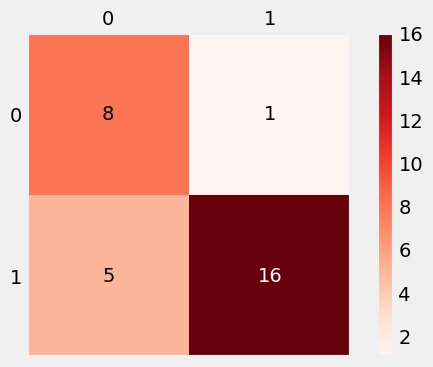

LinearRegression


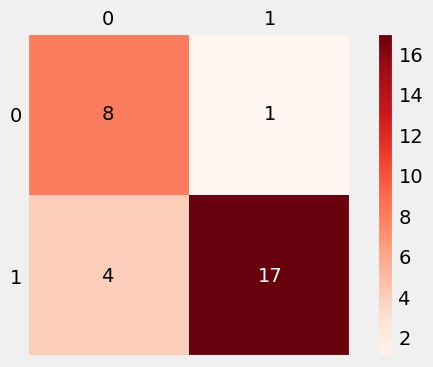

NaiveBayesGaussiano


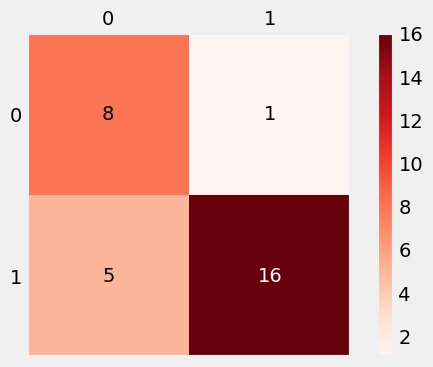

GaussianNB


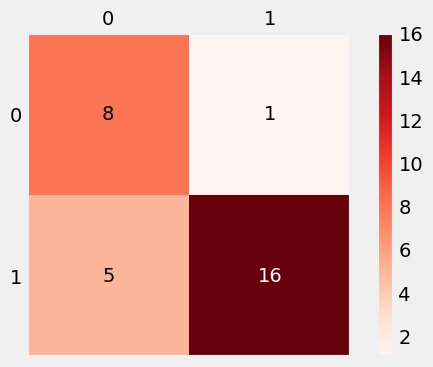

DiscriminanteQuadraticoGaussiano


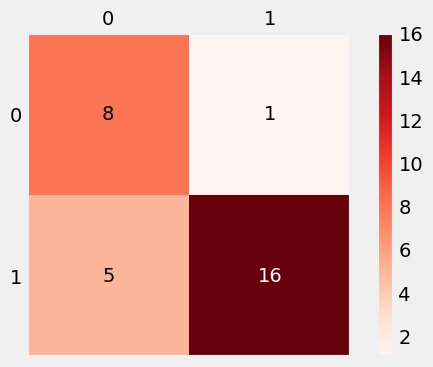

QuadraticDiscriminantAnalysis


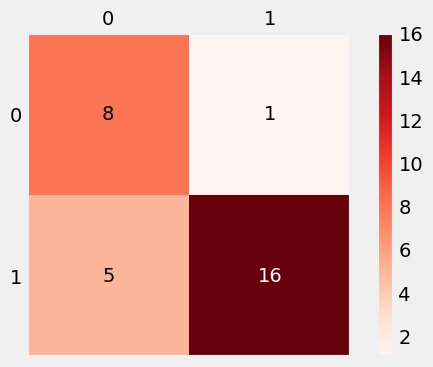

In [24]:
for clf, name in zip(classifiers, names):
    print(name)
    plot_confusion_matrix(X_test, y_test, clf)
    plt.show()

### Fronteiras

RegressaoLinear


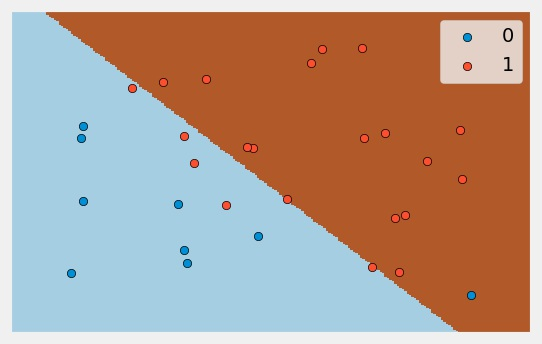

LinearRegression


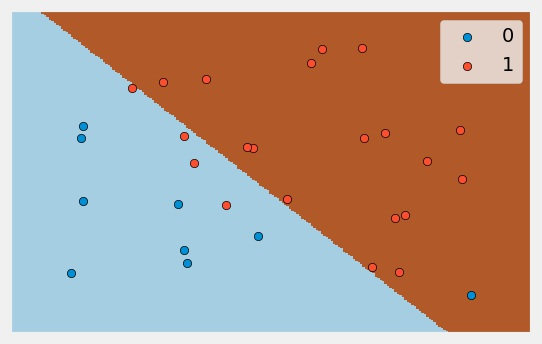

NaiveBayesGaussiano


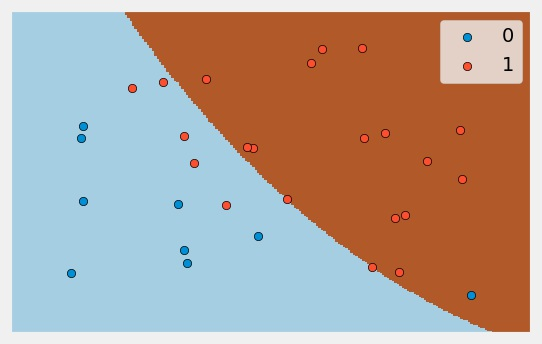

GaussianNB


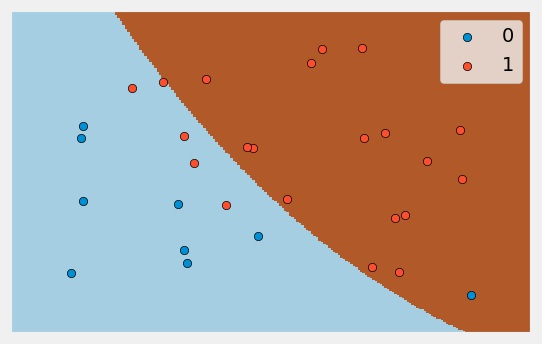

DiscriminanteQuadraticoGaussiano


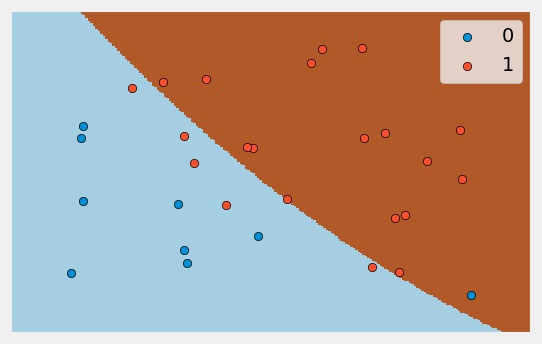

QuadraticDiscriminantAnalysis


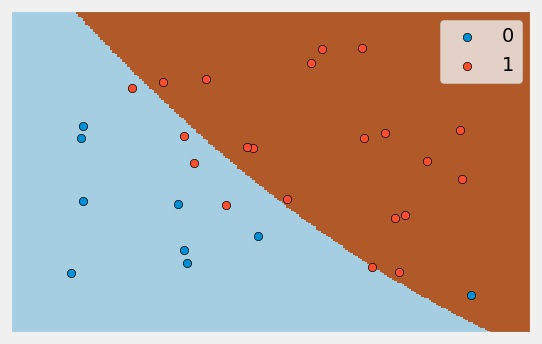

In [25]:
for clf, name in zip(classifiers, names):
    print(name)
    plot_boundaries(X_test, y_test, clf)
    plt.show()

### Conclusões

- O dado parece ser linearmente separável ou não?

    Sim, podemos visualizar nos gráficos de fronteira que as classes podem ser separadas linearmente

- Quais dos métodos produziu fronteiras lineares?

    Os método de Regressão Logística produziu uma fronteira linear, enquanto os métodos Naive Bayes Gaussiano e Discriminante Quadrático Gaussiano produziram fronteiras polinomiais.

- Qual teve melhor acurácia?

    A Regressão Linear, com valor de 0.83 apresentou uma melhor acurácia do que o Naive Bayes Gaussiano e Discriminante Quadrático Gaussiano, que apresentaram valores de de 0.8. Podemos observar nos graficos de fronteira do conjunto de treino abaixo que os métodos Gaussianos aparenta apresentar overfitting devido ao ajuste não linear aos dados.

RegressaoLinear


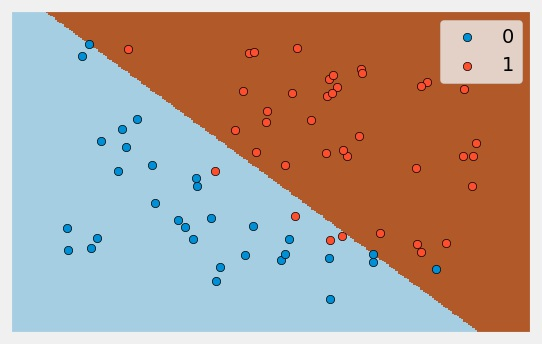

LinearRegression


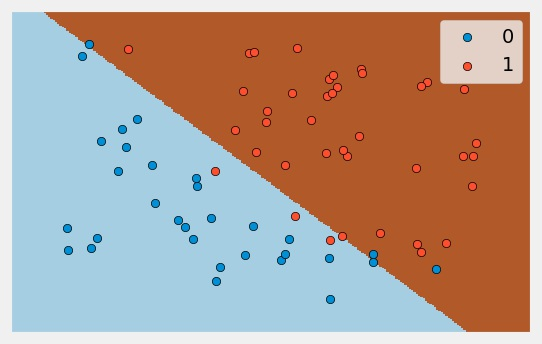

NaiveBayesGaussiano


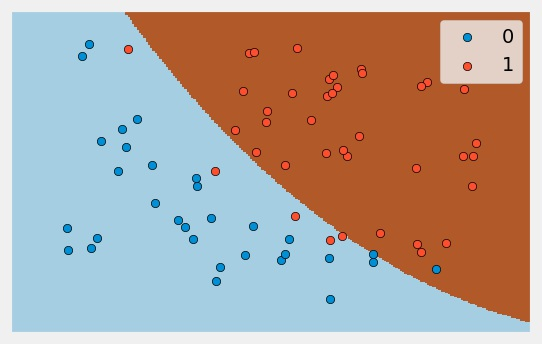

GaussianNB


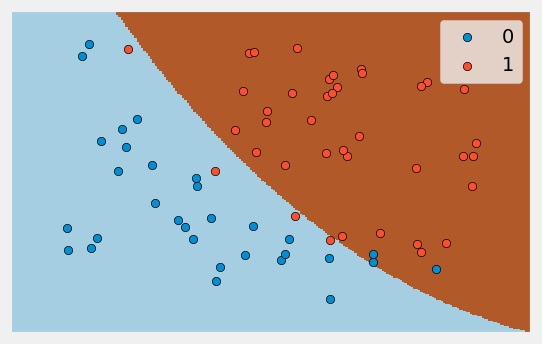

DiscriminanteQuadraticoGaussiano


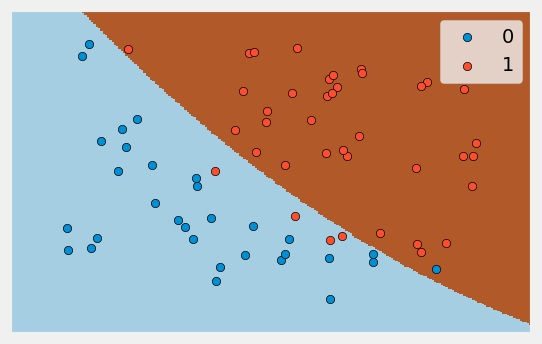

QuadraticDiscriminantAnalysis


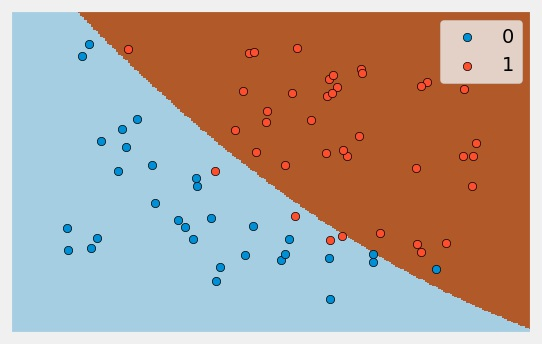

In [26]:
for clf, name in zip(classifiers, names):
    print(name)
    plot_boundaries(X_train, y_train, clf)
    plt.show()

## Exemplo Multiclasse

In [27]:
from sklearn.datasets import make_classification

X, y = make_classification(
    1000, 
    n_features=2, n_clusters_per_class=1, 
    n_informative=2, n_redundant=0, 
    n_classes=4
)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [28]:
reg_log = RegressaoLogisticaGD()
log_reg = LogisticRegression(multi_class='ovr')

In [29]:
reg_log.fit(X_train, y_train, epochs=100, tool=0.0001)
log_reg.fit(X_train, y_train)

LogisticRegression(multi_class='ovr')

In [30]:
nbg = NaiveBayesGaussiano()
gnb = GaussianNB()

In [31]:
nbg.fit(X_train, y_train)
gnb.fit(X_train, y_train)

GaussianNB()

In [32]:
dqg = DiscriminanteQuadraticoGaussiano()
qda = QuadraticDiscriminantAnalysis()

In [33]:
dqg.fit(X_train, y_train)
qda.fit(X_train, y_train)

QuadraticDiscriminantAnalysis()

In [34]:
classifiers = [reg_log, log_reg, nbg, gnb, dqg, qda]
names = [
    'RegressaoLinear', 'LinearRegression', 
    'NaiveBayesGaussiano', 'GaussianNB', 
    'DiscriminanteQuadraticoGaussiano', 'QuadraticDiscriminantAnalysis'
]

In [35]:
for clf, name in zip(classifiers, names):
    print(name, acuracia(y_test, clf.predict(X_test)))

RegressaoLinear 0.7033333333333334
LinearRegression 0.71
NaiveBayesGaussiano 0.7433333333333333
GaussianNB 0.7433333333333333
DiscriminanteQuadraticoGaussiano 0.7866666666666666
QuadraticDiscriminantAnalysis 0.7733333333333333


RegressaoLinear


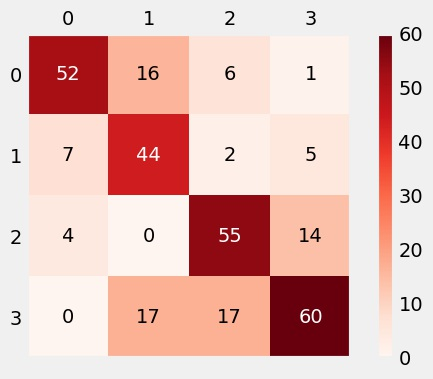

LinearRegression


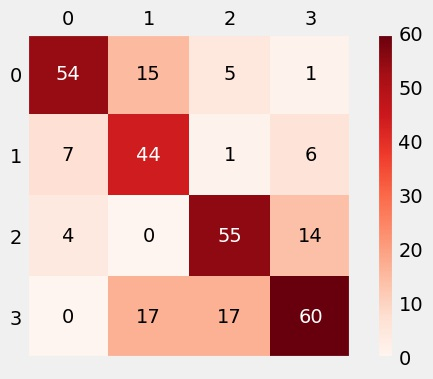

NaiveBayesGaussiano


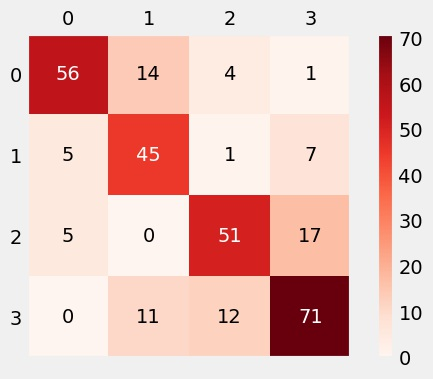

GaussianNB


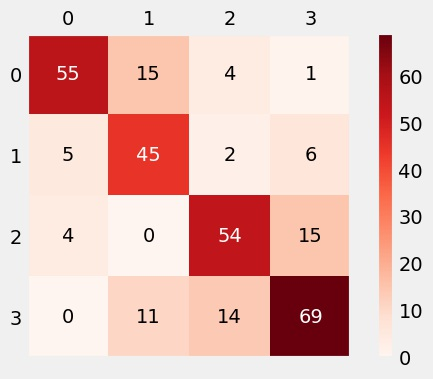

DiscriminanteQuadraticoGaussiano


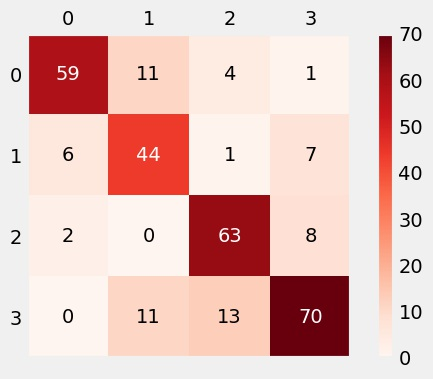

QuadraticDiscriminantAnalysis


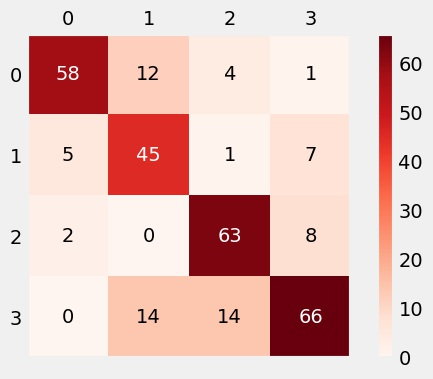

In [36]:
for clf, name in zip(classifiers, names):
    print(name)
    plot_confusion_matrix(X_test, y_test, clf)
    plt.show()

RegressaoLinear


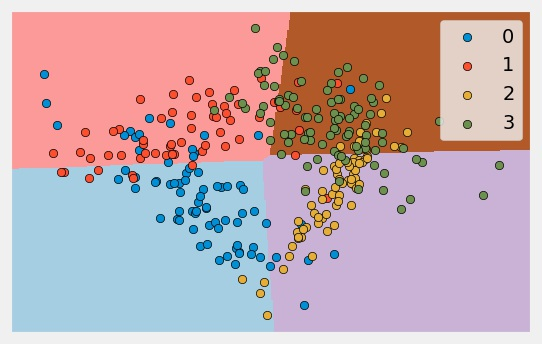

LinearRegression


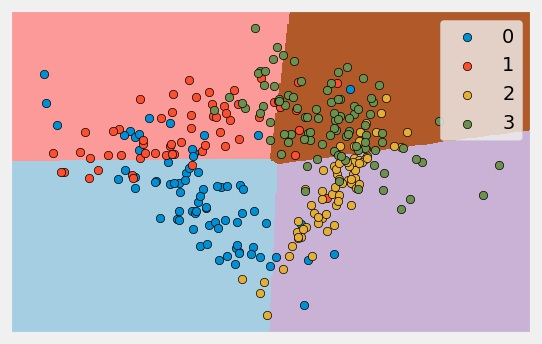

NaiveBayesGaussiano


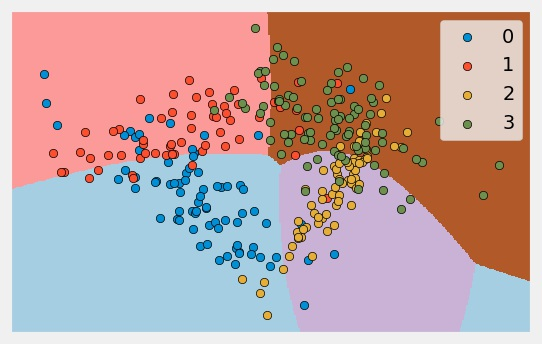

GaussianNB


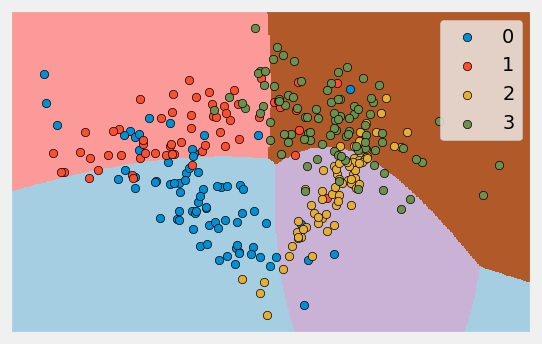

DiscriminanteQuadraticoGaussiano


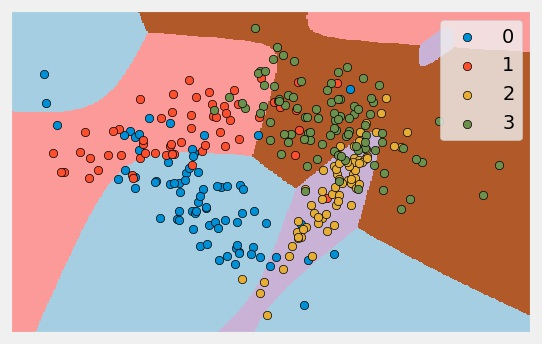

QuadraticDiscriminantAnalysis


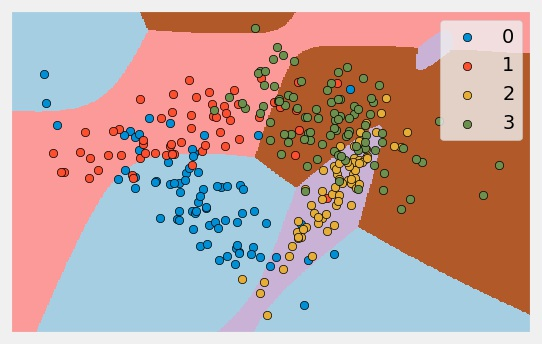

In [37]:
for clf, name in zip(classifiers, names):
    print(name)
    plot_boundaries(X_test, y_test, clf)
    plt.show()